In [270]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

In [271]:
def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)

In [492]:
from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn


class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.elu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

class AutoEncoder(nn.Module):
  encoder_widths: Sequence[int]
  decoder_widths: Sequence[int]
  input_shape: Sequence[int]

  def setup(self):
    input_dim = np.prod(self.input_shape)
    self.encoder = MLP(self.encoder_widths)
    self.decoder = MLP(self.decoder_widths + (input_dim,))

  def __call__(self, x):
    return self.decode(self.encode(x))

  def encode(self, x):
    assert x.shape[1:] == self.input_shape
    return self.encoder(jnp.reshape(x, (x.shape[0], -1)))

  def decode(self, z):
    z = self.decoder(z)
    x = nn.sigmoid(z)
    x = jnp.reshape(x, (x.shape[0],) + self.input_shape)
    return x

In [273]:
class Fishnet(nn.Module):
    theta_fid: jnp.array
    n_hidden_score: list
    n_hidden_fisher: list
    n_inputs: int=1
    n_parameters: int=2
    is_iid: bool=True
    priorCinv: jnp.array = jnp.eye(2)
    priormu: jnp.array = jnp.zeros((2,))

    def setup(self):

        self.model_score = MLP(self.n_hidden_score + (self.n_parameters,))
        self.model_fisher = MLP(self.n_hidden_fisher + (int(self.n_parameters * (self.n_parameters + 1)) // 2,))

    def __call__(self, x):
        
        if self.is_iid:
            score = self.model_score(x)
            fisher_cholesky = self.model_fisher(x)

            F = jax.vmap(self.construct_fisher_matrix_multiple)(fisher_cholesky)

            t = jnp.sum(score, axis=0) - jnp.einsum('ij,j->i', self.priorCinv, (self.theta_fid - self.priormu))
            F = jnp.sum(F, axis=0) + self.priorCinv
            #print("F", F.shape)
            mle = self.theta_fid + jnp.einsum('ijk,ik->ij', jnp.linalg.inv(F), t)

        else:
            score = self.model_score(jnp.squeeze(x))
            fisher_cholesky = self.model_fisher(jnp.squeeze(x))
            F = (self.construct_fisher_matrix_single)(fisher_cholesky)
            mle = self.theta_fid + jnp.einsum('jk,k->j', jnp.linalg.inv(F), score)

        # compute MLE
        
        return mle, score, F
    

    def construct_fisher_matrix_multiple(self, outputs):
        Q = jnp.squeeze(tfp.math.fill_triangular(outputs))
        # vmap the jnp.diag function for the batch
        _diag = jax.vmap(jnp.diag)
        middle = _diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
        padding = jnp.zeros(Q.shape)

        L = Q - fill_diagonal(padding, middle)

        return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (0, 2, 1)))
    
    def construct_fisher_matrix_single(self, outputs):
        Q = tfp.math.fill_triangular(outputs)
        middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
        padding = jnp.zeros(Q.shape)

        L = Q - fill_diagonal(padding, middle)

        return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))


In [267]:
key = jax.random.PRNGKey(0)

model_single = Fishnet(jnp.zeros(2,), 
                n_hidden_fisher=[128,128], 
                n_hidden_score=[128,128],
                n_inputs=1,
                n_parameters=2,
                is_iid=False)

params = model_single.init(key, jax.random.normal(key, (10,)))

mle, score, F = model_single.apply(params, jax.random.normal(key, (10,)))

In [743]:
class FishnetDeepset(nn.Module):
    theta_fid: jnp.array
    n_hidden_score: list
    n_hidden_fisher: list
    n_hidden_globals: list
    n_inputs: int=1
    n_parameters: int=2
    is_iid: bool=True
    priorCinv: jnp.array = jnp.eye(2)
    priormu: jnp.array = jnp.zeros((2,))

    def setup(self):

        self.model_score = MLP(self.n_hidden_score)
        self.model_fisher = MLP(self.n_hidden_fisher)
        self.model_globals = MLP(self.n_hidden_globals + (int(self.n_parameters \
                                        + int(self.n_parameters * (self.n_parameters + 1)) // 2),)
                                            )


    def __call__(self, x):
        
        score = self.model_score(x) #[:, jnp.newaxis]
        fisher_cholesky = self.model_fisher(x) #[:, jnp.newaxis]

        #print(score.shape)

        t = jnp.mean(score, axis=0)#- jnp.einsum('ij,j->i', self.priorCinv, (self.theta_fid - self.priormu))
        fisher_cholesky = jnp.mean(fisher_cholesky, axis=0)

        #print("t", t.shape)
        #print("fisher", fisher_cholesky.shape)

        outputs = self.model_globals(jnp.concatenate([t, fisher_cholesky], axis=-1))
        
        
        t = outputs[:self.n_parameters]
        fisher_cholesky = outputs[self.n_parameters:]

        #
        # print("fisher cholesky", fisher_cholesky.shape)

        F = self.construct_fisher_matrix_single((fisher_cholesky)) + self.priorCinv
        # #+ self.priorCinv

        #mle = t
        mle = t #self.theta_fid + t #jnp.einsum('jk,k->j', jnp.linalg.inv(F), t)

        return mle, score, F
    

    def construct_fisher_matrix_multiple(self, outputs):
        Q = jnp.squeeze(tfp.math.fill_triangular(outputs))
        # vmap the jnp.diag function for the batch
        _diag = jax.vmap(jnp.diag)
        middle = _diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
        padding = jnp.zeros(Q.shape)

        L = Q - fill_diagonal(padding, middle)

        return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (0, 2, 1)))
    
    def construct_fisher_matrix_single(self, outputs):
        Q = tfp.math.fill_triangular(outputs)
        middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
        padding = jnp.zeros(Q.shape)

        L = Q - fill_diagonal(padding, middle)

        return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))


In [607]:
key = jax.random.PRNGKey(0)

model = FishnetDeepset(jnp.ones(2,), 
                n_hidden_fisher=[128,128], 
                n_hidden_score=[128,128],
                n_hidden_globals=[50,50],
                n_inputs=1,
                n_parameters=2,
                is_iid=True)

params = model.init(key, jnp.ones((10,1)))

mle, score, F = model.apply(params, jnp.ones((10,1)))

In [608]:
F.shape

(2, 2)

# do a regression scheme

In [744]:
import jax.random as jr

n_d = 100
input_shape = (n_d,)

@jax.jit
def Fisher(θ, n_d=n_d):
    Σ = θ[1]
    return jnp.array([[n_d / Σ, 0.], [0., n_d / (2. * Σ**2.)]])


def simulator(key, θ):
    return θ[0] + jax.random.normal(key, shape=input_shape) * jnp.sqrt(θ[1])


key = jr.PRNGKey(0)

key1,key2 = jr.split(key)

mu_ = jr.uniform(key1, shape=(10000,), minval=-2, maxval=2)
sigma_ = jr.uniform(key2, shape=(10000,), minval=0.5, maxval=3.0)

theta_ = jnp.stack([mu_, sigma_], axis=-1)

keys = jr.split(key, num=10000)

data = jax.vmap(simulator)(keys, theta_)[:, :, jnp.newaxis]

In [745]:
# train the network for iid data
key = jax.random.PRNGKey(0)

model = FishnetDeepset(jnp.ones(2,), 
                n_hidden_fisher=[128,128], 
                n_hidden_score=[128,128],
                n_hidden_globals=[50,50],
                n_inputs=1,
                n_parameters=2)

w = model.init(key, jnp.ones((100,1)))

mle, score, F = model.apply(w, jnp.ones((100,1)))

In [746]:
mle

Array([0.06356273, 0.3846488 ], dtype=float32)

In [747]:
np.linalg.det(F)

3.4400883

In [748]:
@jax.jit
def kl_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       mle,score,F = model.apply(w, x)
       return mle, F
    
    mle, F = jax.vmap(fn)(x_batched, theta_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)

In [749]:
kl_loss(w, data[:10], theta_[:10])

Array(3.291766, dtype=float32)

In [842]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


batch_size = 100
epochs = 100

w = w

losses = []
#val_losses = []

In [899]:
from tqdm import tqdm
batch_size = 100
epochs = 100

key = jax.random.PRNGKey(99)

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
  key,rng = jax.random.split(key)

  for i in range(len(data) // batch_size):
    x_samples = data[batch_size*i:(batch_size*(i+1))]
    y_samples = theta_[batch_size*i:(batch_size*(i+1))]

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)

    #if i % 10 == 0:

    #  val_loss, _ = loss_grad_fn(w, X_test, y_test)
      #print('loss step {}: '.format(i), loss_val)
      #print('val loss step {}: '.format(i), val_loss_val)
      
  losses.append(loss_val)
  #val_losses.append(val_loss)
  pbar.set_description('epoch loss %d: %.4f'%(j, loss_val))

epoch loss 99: -2.8630: 100%|██████████| 100/100 [09:58<00:00,  5.98s/it]


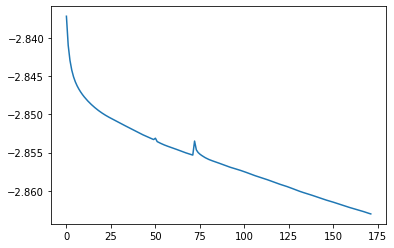

In [900]:
plt.plot(losses)

In [901]:
_app = lambda d: model.apply(w, d)

mle_pred,_,F_pred = jax.vmap(_app)(data[-1000:])

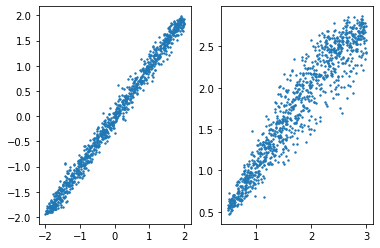

In [902]:
plt.subplot(121)
plt.scatter(theta_[-1000:, 0], mle_pred[:, 0], s=2)
plt.subplot(122)
plt.scatter(theta_[-1000:, 1], mle_pred[:, 1], s=2)

In [903]:
@jax.jit
def Fisher(θ, n_d=n_d):
    Σ = θ[1]
    return jnp.array([[n_d / Σ, 0.], [0., n_d / (2. * Σ**2.)]])

F_true = jax.vmap(Fisher)(theta_[-1000:])

In [904]:
F_true[:5]

Array([[[112.028824,   0.      ],
        [  0.      ,  62.75229 ]],

       [[192.69997 ,   0.      ],
        [  0.      , 185.66637 ]],

       [[ 50.472633,   0.      ],
        [  0.      ,  12.737433]],

       [[ 91.64879 ,   0.      ],
        [  0.      ,  41.9975  ]],

       [[ 46.800247,   0.      ],
        [  0.      ,  10.951315]]], dtype=float32)

In [905]:
F_pred[:5]

Array([[[137.90695   ,   1.9110353 ],
        [  1.9110353 ,  42.601818  ]],

       [[176.65952   ,   4.7994337 ],
        [  4.7994337 , 149.46686   ]],

       [[ 44.73905   ,   0.44742754],
        [  0.44742754,  12.157181  ]],

       [[ 80.492905  ,   1.729578  ],
        [  1.729578  ,  29.589249  ]],

       [[ 42.33445   ,  -0.85279983],
        [ -0.85279983,  18.461662  ]]], dtype=float32)

In [906]:
θ_fid = jnp.array([0.0, 1.25])

lo = [-1.0, 0.5]
hi = [1.0, 3.0]

num = 10

xs = jnp.linspace(-1.0, 1.0, num) # MEAN
ys = jnp.linspace(0.5, 3.0, num) #jnp.logspace(-1.0, 0.0, num) # VARIANCE


xs,ys = jnp.meshgrid(xs, ys)

fishers = []

for _mu,_sigma in zip(xs.ravel(), ys.ravel()):
  fishers.append(Fisher(jnp.array([_mu,_sigma]), n_d=n_d))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


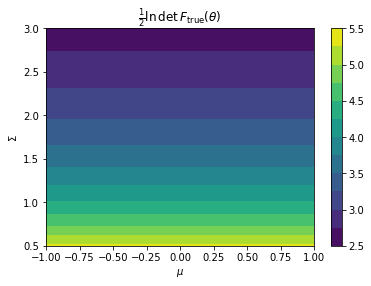

In [907]:
_data = jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape) #/ ys #jnp.array(fishers)[:, 0, 0].reshape(xs.shape) / ys #jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape)

im = plt.contourf(xs, ys, 0.5*np.log(_data), cmap='viridis', levels=10)
cbar = plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'$ \frac{1}{2} \ln \det F_{\rm true}(\theta)$')
plt.legend(framealpha=0., loc='lower left')
plt.show()

In [908]:
fishers_pred = []

key = jr.PRNGKey(99)
n_d_test = 500

def _getf(d):
    return model.apply(w, d)[2]


for mu,sigma in tqdm(zip(xs.ravel(), ys.ravel())):
  # generate many data realization at each gridpoint
    key, rng = jr.split(key)
    keys = jr.split(key, 2000)

    sims = jax.vmap(simulator)(keys, jnp.tile(jnp.array([[mu], [sigma]]), 2000).T)[:, :, jnp.newaxis]
    
    fpreds = jax.vmap(_getf)(sims)

    fishers_pred.append(jnp.mean(fpreds, axis=0))

100it [00:32,  3.06it/s]


In [861]:
jnp.linalg.det(fishers[30])


Array(2109.3748, dtype=float32)

In [862]:
jnp.linalg.det(fishers_pred[30])

Array(1917.566, dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


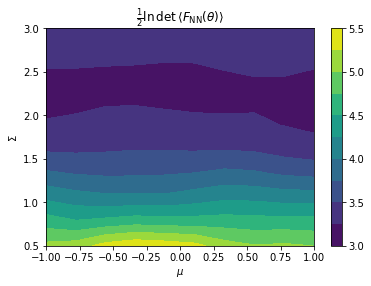

In [911]:
_data = jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred)).reshape(xs.shape) #/ ys#jnp.array(fishers_pred)[:, 1, 1].reshape(xs.shape) / ys#jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred)).reshape(xs.shape)

im = plt.contourf(xs, ys, 0.5*np.log(_data), cmap='viridis', levels=10)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'$ \frac{1}{2} \ln \det \langle F_{\rm NN}(\theta) \rangle $')
plt.legend(framealpha=0., loc='lower left')
plt.show()

In [918]:
pwd

'/Users/lucas/repositories/fishnets'

In [919]:
np.save("iidnoise_fishers_pred", fishers_pred)
np.save("iidnoise_fishers_true", fishers)

np.save("xy_grid", (xs, ys))

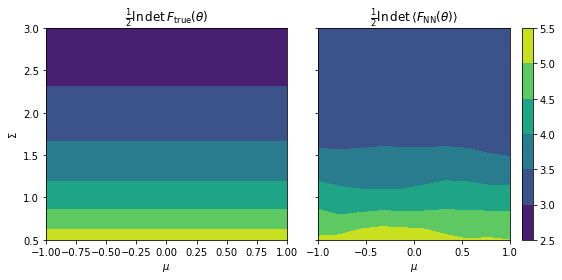

In [920]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex="col", sharey=True)
(ax1, ax2) = axs

levels = [2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

dets1 =  jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape)

ax1.contourf(xs, ys, 0.5*np.log(dets1), cmap='viridis', levels=levels)

dets2 = jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred)).reshape(xs.shape) 

cs2 = ax2.contourf(xs, ys, 0.5*np.log(dets2), cmap='viridis', levels=levels)

plt.colorbar(cs2)

ax1.set_title(r'$ \frac{1}{2} \ln \det F_{\rm true}(\theta)$')

ax1.set_ylabel('$\Sigma$')
ax1.set_xlabel('$\mu$')

ax2.set_xlabel('$\mu$')
ax2.set_title(r'$ \frac{1}{2} \ln \det \langle F_{\rm NN}(\theta) \rangle $')
plt.tight_layout()

plt.savefig("/Users/lucas/Documents/Documents - MacBook Pro di Admin/imperial/fishnets/info-comparison.png", dpi=400)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


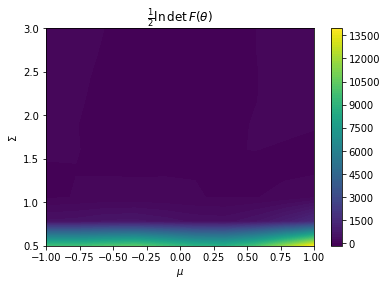

In [810]:
_data = jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred) - jnp.array(fishers)).reshape(xs.shape)


im = plt.contourf(xs, ys, (_data), cmap='viridis', levels=100)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'$ \frac{1}{2} \ln \det F(\theta)$')
plt.legend(framealpha=0., loc='lower left')
plt.show()

In [421]:
fishers[200]

Array([[9.830508, 0.      ],
       [0.      , 4.831945]], dtype=float32)